In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from util import *

In [33]:
import glob
from nexrad import get_lat_lon
import time as t
import util

root = '../data'
max_scans = 1000
stations = ['KENX']
years = [2017]

file_list_folder = f'{root}/file_lists/station_year_lists'

if not os.path.exists(f"{root}/scan_level"):
    os.makedirs(f"{root}/scan_level")

lat_lon = get_lat_lon()

# TODO: could potentially be sped up by loading many profiles at once and using pandas commands, including
# TODO: group by to group by scan

paths = glob.glob(f'{file_list_folder}/*.txt')
filenames = [os.path.basename(p) for p in paths]
all_stations = set([f[:4] for f in filenames])

stations = stations or all_stations

num_scans = 0    
for station in stations:
    for year in years:

        station_year = f"{station}-{year}"
        print(station_year)

        path = f"{file_list_folder}/{station}-{year}.txt"            
        if path not in paths:
            warnings.warn(f"{path} not found")
            continue

        with open(path, 'r') as infile:
            print(path)
            profile_paths = infile.read().split('\n')

        start = t.time()
        outfile = f'{root}/scan_level/{station_year}.csv'

        column_names = ['station',                    # 0
                        'lat',                        # 1
                        'lon',                        # 2
                        'date',                       # 3
                        'density',                    # 4
                        'density_precip',             # 5
                        'traffic_rate',               # 6
                        'traffic_rate_precip',        # 7
                        'u',                          # 8
                        'v',                          # 9
                        'speed',                      # 10
                        'direction',                  # 11
                        'percent_rain']               # 12

        # Get rows from individual files
        rows = []
        for filename in profile_paths:
            if max_scans and num_scans >= max_scans:
                break
            rows.append(util.aggregate_profile_to_scan_level(f"{root}/{filename}", lat_lon))
            num_scans += 1

        df = pd.DataFrame(rows, columns=column_names)

        do_solar_elevation = True
        if do_solar_elevation:
            # Add solar elevation (note: much faster to do in batch at end than row-by-row)
            solar_elev = pvlib.solarposition.spa_python(df['date'], df['lat'], df['lon'])
            df['solar_elevation'] = solar_elev['elevation'].values

            # Convert lat/lon to strings to preserve full precision --- other floats will be truncated
            df['lat'] = df['lat'].apply(str)
            df['lon'] = df['lon'].apply(str)

            # Add solar elevation to column names and write to file
            column_names.insert(4, 'solar_elevation')

        df.to_csv(outfile, columns=column_names, index=False, float_format='%.4f')

        n_scans = len(rows)

        elapsed = t.time()-start
        if n_scans > 0:
            print(f'  time={elapsed:.2f}, scans={n_scans}, per scan={elapsed/n_scans:.4f}')


KENX-2017
../data/file_lists/station_year_lists/KENX-2017.txt
  time=10.85, scans=1000, per scan=0.0109


In [73]:
'''
Summarize vertical profiles across height dimension and aggregate to 
one row per scan
'''
def aggregate_profiles_to_scan_level(infiles, station_info):
    
    keep_cols = ['linear_eta',
                 'linear_eta_unfiltered',
                 'speed',
                 'u',
                 'v',
                 'nbins',
                 'percent_rain',
                 'rmse']
    

    bin_width_m = 100
    bin_width_km = 100/1000

    meta_df = pd.DataFrame({'station': [],
                            'lat' : [], 
                            'lon' : [], 
                            'date' : []})
    
    # Read files, add profile data to df and metadata to meta_df 
    df = pd.DataFrame()
    for i, infile in enumerate(infiles):

        # Read profile and add to dataframe
        '''Produce scan-level summary for a vertical profile'''        
        scan_df = pd.read_csv(infile)        
        assert (scan_df['bin_lower'].diff()[1:]==bin_width_m).all()
        scan_df = scan_df[keep_cols]
        scan_df['file_number'] = i
        df = pd.concat([df, scan_df])
                
        # Collect scan metadata
        infile = infile.split('/')[-1]
        station = infile[:4]
        year = infile[4:8]
        month = infile[8:10]
        day = infile[10:12]
        hour = infile[13:15]
        minute = infile[15:17]
        second = infile[17:19]

        meta_df.loc[i] = [station, 
                          station_info[station]['lat'],
                          station_info[station]['lon'],
                          f"{year}-{month}-{day} {hour}:{minute}:{second}Z"]
        
    # Vertically integrated reflectivity (vir)
    #
    #  -- units in each elevation bin are reflectivity (cm^2/km^3)
    #
    #  -- multiply by height of each bin in km to get cm^2/km^2
    #
    #     == total scattering area in that elevation bin per 1 sq km.
    #        of area in x-y plane
    #
    #  -- add values together to get total scattering area in a column
    #     above a 1km patch on the ground (cm^2/km^2)
    #
    #  -- (NOTE: can multiply these values by 10^-8 to get units
    #      km^2/km^2, i.e., a unitless quantity. Interpretation: total
    #      fraction of a 1 square km patch on the ground that would be
    #      filled by the total scattering area of targets in the column
    #      above it. I.e., zap all the birds so they fall to the
    #      ground, and measure how much ground space is filled up.)

    # Speed converted from m/s to km/h
    speed_km_h = df['speed'] * (1/1000) * (3600/1)

    weighted_average_cols = [('speed', 'linear_eta'),
                             ('u', 'linear_eta'),
                             ('v', 'linear_eta'),
                             ('rmse', 'linear_eta'),
                             ('percent_rain', 'nbins')]

    # For columns where we will compute weighted averages, multiply
    # by the appropriate weight column
    for col, weight_col in weighted_average_cols:
        df[col] *= df[weight_col]

    # For vertically integrated reflectivity, units cm2 / km2
    df['density'] = df['linear_eta'] * bin_width_km
    df['density_unfiltered'] = df['linear_eta_unfiltered'] * bin_width_km

    # For vertically integrated traffic rate, units cm2 / km / h
    df['traffic_rate'] = df['linear_eta'] * speed_km_h * bin_width_km
    df['traffic_rate_unfiltered'] = df['linear_eta_unfiltered'] * speed_km_h * bin_width_km

    # Do vertical integration for each scan
    df = df.groupby('file_number').sum()    
    
    # Complete the weighted average calculation by dividing by total weights
    for col, weight_col in weighted_average_cols:
        df[col] /= df[weight_col]

    # Derived columns
    df['density_precip'] = df['density_unfiltered'] - df['density']
    df['traffic_rate_precip'] = df['traffic_rate_unfiltered'] - df['traffic_rate']

    # Average track as compass bearing (degrees clockwise from north)
    df['direction'] = pol2cmp(np.arctan2(df['v'], df['u']))

    # Keep selected columns
    df = df[['density', 
             'density_precip', 
             'traffic_rate', 
             'traffic_rate_precip',
             'u',
             'v',
             'speed',
             'direction',
             'percent_rain',
             'rmse']]
    
    df = meta_df.join(df)
    
    return df
    

df = aggregate_profiles_to_scan_level(infiles, lat_lon)
display(df)

,station,lat,lon,date,density,density_precip,traffic_rate,traffic_rate_precip,u,v,speed,direction,percent_rain,rmse
0,KENX,42.58639,-74.06444,2017-01-01 00:03:42Z,0.54010,3018.94732,39.812404,331511.207807,16.072817,11.213007,20.475840,55.098910,0.946946,3.229560
1,KENX,42.58639,-74.06444,2017-01-01 00:09:31Z,0.48886,2531.46413,38.164640,278759.044890,17.863645,10.987284,21.685736,58.405826,0.935892,3.197315


In [6]:


def test_load_station_year(root):
    df = load_station_year(root, "KBOX", 2016)
    display(df)
    
def test_day_info():
    day_info = get_day_info("KBOX", 2016)
    display(day_info)

root = '../data'
test_load_station_year(root)
test_day_info()

Loading ../data/scan_level/KBOX-2016.csv


,station,lat,lon,solar_elevation,density,density_precip,traffic_rate,traffic_rate_precip,u,v,speed,direction,percent_rain
date,,,,,,,,,,,,,
2016-12-01 00:03:12+00:00,KBOX,41.95583,-71.1375,-30.7850,1.8951,6128.0522,90.3063,294037.1971,-6.4099,8.4324,13.2367,322.7597,0.5931
2016-12-01 00:09:01+00:00,KBOX,41.95583,-71.1375,-31.8656,1.5697,6285.1384,77.9268,301196.8119,-8.8222,1.4183,13.7899,279.1332,0.6273
2016-12-01 00:14:52+00:00,KBOX,41.95583,-71.1375,-32.9530,1.0759,6483.9055,48.3805,312639.1989,-3.8236,5.2976,12.4914,324.1799,0.6712
2016-12-01 00:20:41+00:00,KBOX,41.95583,-71.1375,-34.0345,0.9854,6356.3596,40.7778,306876.1506,-2.5783,5.9231,11.4952,336.4765,0.7170
2016-12-01 00:26:30+00:00,KBOX,41.95583,-71.1375,-35.1159,1.3874,6233.1429,52.7665,303658.8732,-2.7831,6.0545,10.5644,335.3129,0.7486
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:42:47+00:00,KBOX,41.95583,-71.1375,13.4903,8.7774,0.2242,1078.4337,20.1512,2.1898,33.8813,34.1290,3.6980,0.0329
2016-12-31 20:12:00+00:00,KBOX,41.95583,-71.1375,9.7395,9.2307,0.6596,1188.7351,73.3081,-1.5150,35.0527,35.7725,357.5251,0.0191
2016-12-31 20:41:14+00:00,KBOX,41.95583,-71.1375,5.6256,11.5546,1.5801,1513.6531,165.0603,-0.8329,36.0919,36.3890,358.6779,0.0213


,sunrise,sunset,transit,date,next_sunrise
2016-01-01 00:00:00+00:00,2016-01-01 12:12:26.480490752+00:00,2016-01-01 21:23:36.614387200+00:00,2016-01-01 16:47:57.305959680+00:00,2016-01-01,2016-01-02 12:12:31.958917632+00:00
2016-01-02 00:00:00+00:00,2016-01-02 12:12:31.958917632+00:00,2016-01-02 21:24:28.291636736+00:00,2016-01-02 16:48:25.490753024+00:00,2016-01-02,2016-01-03 12:12:35.102720768+00:00
2016-01-03 00:00:00+00:00,2016-01-03 12:12:35.102720768+00:00,2016-01-03 21:25:21.645841920+00:00,2016-01-03 16:48:53.349678080+00:00,2016-01-03,2016-01-04 12:12:35.905754112+00:00
2016-01-04 00:00:00+00:00,2016-01-04 12:12:35.905754112+00:00,2016-01-04 21:26:16.621244416+00:00,2016-01-04 16:49:20.852032256+00:00,2016-01-04,2016-01-05 12:12:34.363850496+00:00
2016-01-05 00:00:00+00:00,2016-01-05 12:12:34.363850496+00:00,2016-01-05 21:27:13.160422912+00:00,2016-01-05 16:49:47.967257344+00:00,2016-01-05,2016-01-06 12:12:30.474694656+00:00
...,...,...,...,...,...
2016-12-27 00:00:00+00:00,2016-12-27 12:11:37.342236160+00:00,2016-12-27 21:20:17.219565824+00:00,2016-12-27 16:45:54.733510400+00:00,2016-12-27,2016-12-28 12:11:52.784586240+00:00
2016-12-28 00:00:00+00:00,2016-12-28 12:11:52.784586240+00:00,2016-12-28 21:21:01.377882624+00:00,2016-12-28 16:46:24.131821312+00:00,2016-12-28,2016-12-29 12:12:05.932393472+00:00
2016-12-29 00:00:00+00:00,2016-12-29 12:12:05.932393472+00:00,2016-12-29 21:21:47.410730752+00:00,2016-12-29 16:46:53.322018048+00:00,2016-12-29,2016-12-30 12:12:16.765108224+00:00
2016-12-30 00:00:00+00:00,2016-12-30 12:12:16.765108224+00:00,2016-12-30 21:22:35.264818688+00:00,2016-12-30 16:47:22.267416576+00:00,2016-12-30,2016-12-31 12:12:25.264386816+00:00


,station,lat,lon,date,period,period_length,percent_missing,percent_filled,density_hours,density_hours_precip,traffic,traffic_precip,u,v,direction,speed,percent_rain
0,KBOX,41.9558,-71.1375,2017-01-01,day,9.19578,0.000000,0.027273,101.1440,7.067810,8437.29,366.6360,15.92190,-11.06830,114.715,23.2201,0.036834
1,KBOX,41.9558,-71.1375,2017-01-02,day,9.20944,0.000000,0.000000,148.0520,2101.310000,12529.50,71561.3000,-3.01384,8.38700,277.532,23.5053,0.095357
2,KBOX,41.9558,-71.1375,2017-01-03,day,9.22421,0.000000,0.000000,1260.0700,13508.300000,63293.20,703280.0000,-12.64430,2.56858,281.294,13.9725,0.539314
3,KBOX,41.9558,-71.1375,2017-01-04,day,9.24007,0.000000,0.000000,127.1070,239.067000,8559.61,15325.0000,6.91778,7.12025,120.285,18.7167,0.074316
4,KBOX,41.9558,-71.1375,2017-01-05,day,9.25700,0.000000,0.000000,96.5570,0.840142,10976.00,83.9120,13.00010,-3.95793,150.113,31.5906,0.009215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,KBOX,41.9558,-71.1375,2017-12-27,night,14.86180,0.000000,0.000000,51.3665,0.563608,5979.36,53.9240,1.10483,6.89739,225.645,32.2676,0.012992
726,KBOX,41.9558,-71.1375,2017-12-28,night,14.85350,0.000000,0.000000,48.1144,12.733000,5032.67,621.2020,1.28692,0.68629,222.819,29.1735,0.009453
727,KBOX,41.9558,-71.1375,2017-12-29,night,14.84400,0.000000,0.000000,41.0868,0.790925,4740.85,48.6037,1.61297,8.55208,206.472,32.1588,0.003249
728,KBOX,41.9558,-71.1375,2017-12-30,night,14.83330,0.000000,0.258427,44.7178,1147.660000,3401.32,38750.4000,7.31940,-6.46641,126.432,21.5364,0.206796


/Users/sheldon/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:71: UserWarning: Attempting to set identical left == right == 41.9558 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])
/Users/sheldon/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:80: UserWarning: Attempting to set identical left == right == -71.1375 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/Users/sheldon/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:81: UserWarning: Attempting to set identical bottom == top == 41.9558 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/Users/sheldon/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:80: UserWarning: Attempting to set identical left == right == 41.9558 results in singular transformations; automatically expandin

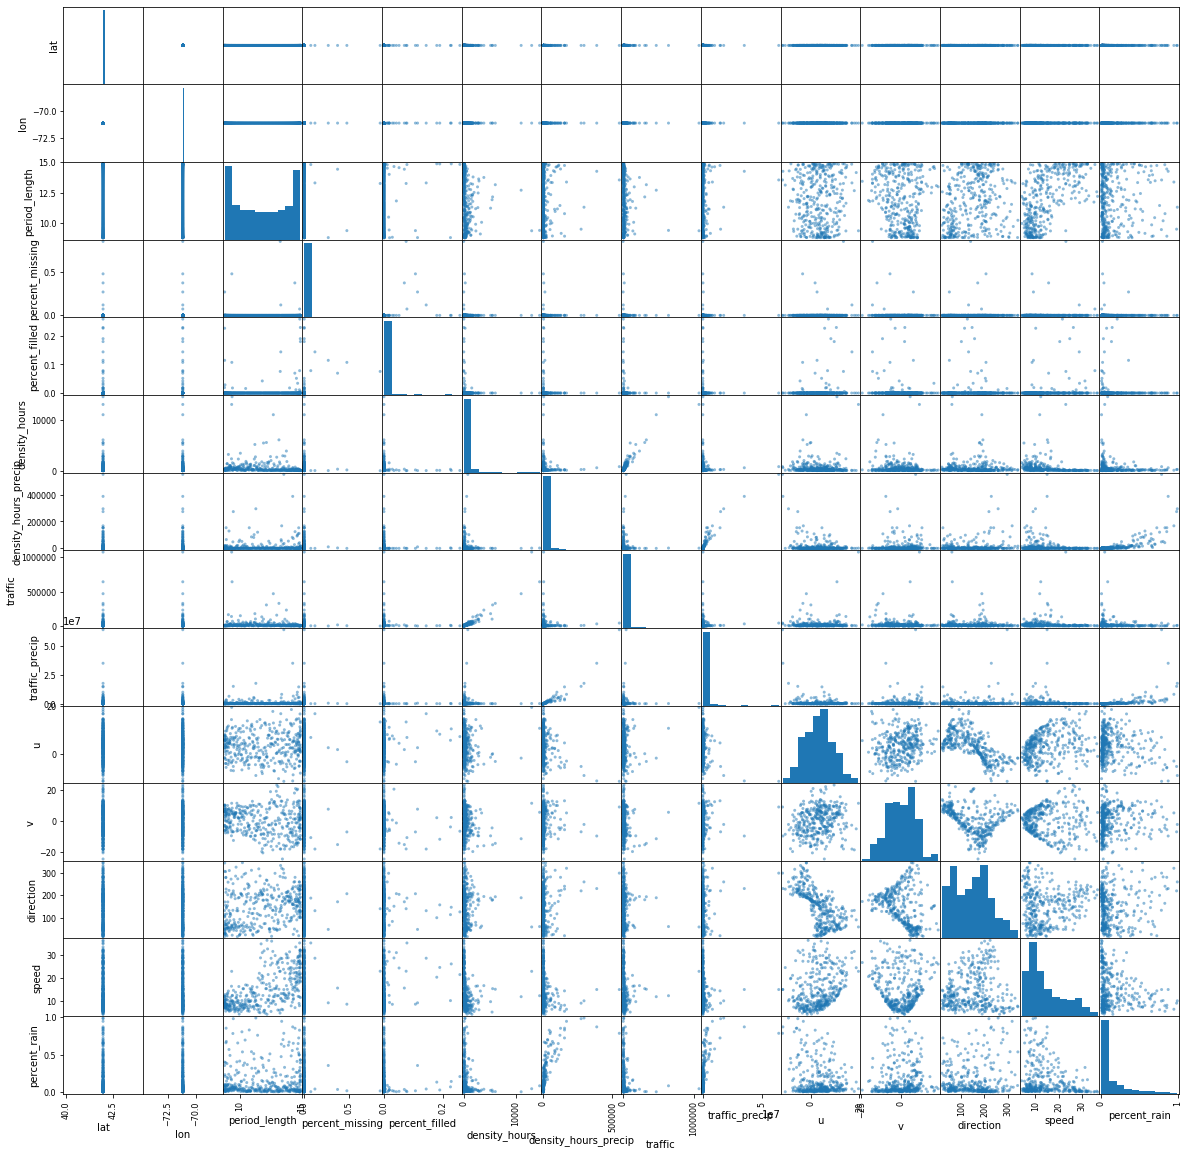

In [25]:
df = pd.read_csv('../data/daily/KBOX_2017.csv')
display(df)
pd.set_option('display.max_rows', 500)

night = df[df['period']=='night']
pd.plotting.scatter_matrix(night, figsize=(20,20))
plt.show()

In [ ]:
night.corr()

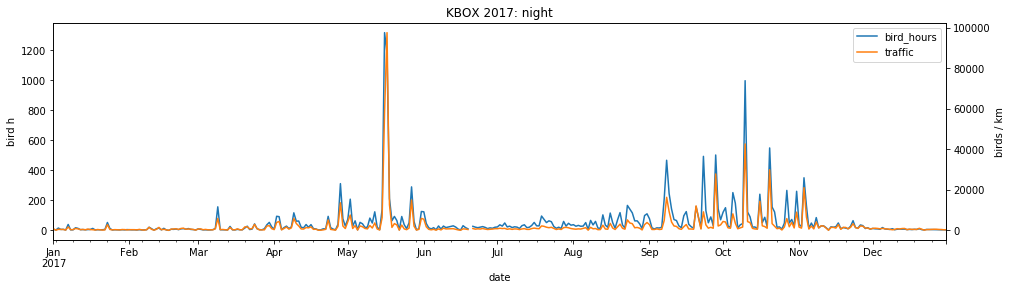

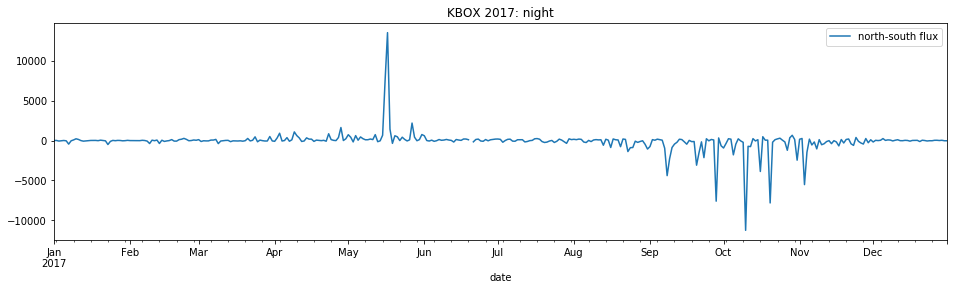

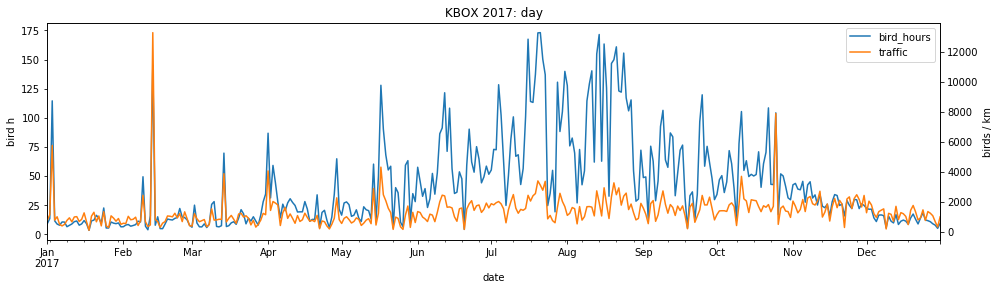

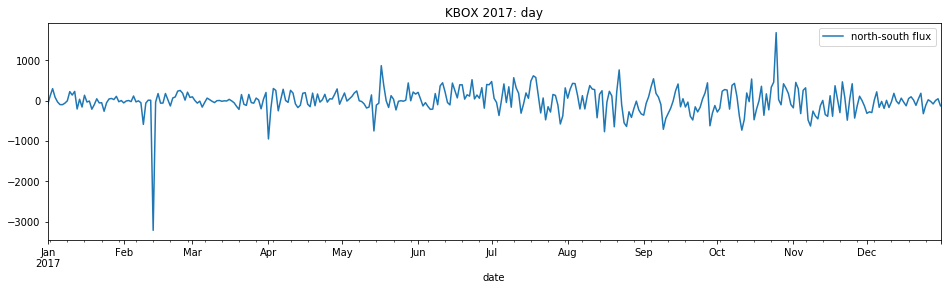

In [26]:
station = 'KBOX'
year = 2017
root = '../data'

file = f'{root}/daily/{station}_{year}.csv'

df = pd.read_csv(file)
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

bird_rcs = 11


for period in ['night', 'day']:
    plt.figure(figsize=(16,4))

    rows = df[df['period']==period]
    plt.title(f'{station} {year}: {period}')
    avg_speed = wtd_mean(rows['density_hours'], rows['speed'])

    bird_hours = rows['density_hours'] / bird_rcs
    bird_hours.name = 'bird_hours'
    ax = bird_hours.plot()
    plt.ylabel('bird h')

    (rows['traffic'] / bird_rcs).plot(secondary_y=True)
    plt.ylabel('birds / km')
    
    lines = ax.get_lines() + ax.right_ax.get_lines()
    ax.legend(lines, [l.get_label() for l in lines], loc='upper right')
    plt.show()
    
    
    plt.figure(figsize=(16,4))
    plt.title(f'{station} {year}: {period}')
    flux = (rows['v'] * bird_hours)
    flux.name = 'north-south flux'
    flux.plot()
    plt.legend()
    plt.show()

In [10]:
print(avg_speed)

9.032742240025605


In [11]:
df

,station,lat,lon,period,period_length,percent_missing,percent_filled,density_hours,density_hours_precip,traffic,traffic_precip,u,v,direction,speed,percent_rain
date,,,,,,,,,,,,,,,,
2017-01-01,KBOX,41.9558,-71.1375,day,9.19578,0.000000,0.027273,101.1440,7.067840,8437.29,366.6360,15.92190,-11.068300,114.715,23.2201,0.038779
2017-01-02,KBOX,41.9558,-71.1375,day,9.20944,0.000000,0.000000,148.0520,2101.310000,12529.50,71561.3000,-3.01384,8.387000,277.532,23.5053,0.098553
2017-01-03,KBOX,41.9558,-71.1375,day,9.22421,0.000000,0.000000,1260.0700,13508.300000,63293.20,703280.0000,-12.64430,2.568570,281.294,13.9725,0.528525
2017-01-04,KBOX,41.9558,-71.1375,day,9.24007,0.000000,0.000000,127.1070,239.067000,8559.61,15325.0000,6.91779,7.120250,120.285,18.7167,0.074006
2017-01-05,KBOX,41.9558,-71.1375,day,9.25700,0.000000,0.000000,96.5570,0.840109,10976.00,83.9120,13.00010,-3.957940,150.113,31.5906,0.009182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,KBOX,41.9558,-71.1375,night,14.86180,0.000000,0.000000,51.3665,0.563653,5979.36,53.9240,1.10483,6.897390,225.645,32.2676,0.013020
2017-12-28,KBOX,41.9558,-71.1375,night,14.85350,0.000000,0.000000,48.1144,12.733000,5032.67,621.2020,1.28691,0.686294,222.819,29.1735,0.010071
2017-12-29,KBOX,41.9558,-71.1375,night,14.84400,0.000000,0.000000,41.0868,0.790941,4740.85,48.6037,1.61298,8.552060,206.472,32.1588,0.003203


In [12]:
t = pd.date_range(start='2020-01-01', periods=8, freq='5M')
x = pd.Series([np.nan, np.nan, 1, 2, np.nan, 3, np.nan, np.nan], index=t)

x.interpolate(limit=2,
              method='values',
              limit_direction='both')


2020-01-31    1.000000
2020-06-30    1.000000
2020-11-30    1.000000
2021-04-30    2.000000
2021-09-30    2.503289
2022-02-28    3.000000
2022-07-31    3.000000
2022-12-31    3.000000
Freq: 5M, dtype: float64

In [14]:
dt = 5/60  # Time increment in hours
dt_obj = pd.DateOffset(hours=dt) # Time increment object

dt_obj / pd.Timedelta('1h')

TypeError: unsupported operand type(s) for /: 'DateOffset' and 'Timedelta'

In [24]:
pd.date_range('2021-01-01', '2021-01-02', freq=pd.Timedelta('5min'))

DatetimeIndex(['2021-01-01 00:00:00', '2021-01-01 00:05:00',
               '2021-01-01 00:10:00', '2021-01-01 00:15:00',
               '2021-01-01 00:20:00', '2021-01-01 00:25:00',
               '2021-01-01 00:30:00', '2021-01-01 00:35:00',
               '2021-01-01 00:40:00', '2021-01-01 00:45:00',
               ...
               '2021-01-01 23:15:00', '2021-01-01 23:20:00',
               '2021-01-01 23:25:00', '2021-01-01 23:30:00',
               '2021-01-01 23:35:00', '2021-01-01 23:40:00',
               '2021-01-01 23:45:00', '2021-01-01 23:50:00',
               '2021-01-01 23:55:00', '2021-01-02 00:00:00'],
              dtype='datetime64[ns]', length=289, freq='5T')

In [28]:
freq = pd.Timedelta('5min')
pd.Timedelta(freq) / pd.Timedelta('1h')

0.08333333333333333

In [82]:
np.tile([1, 2, 3, 4], (5, 1)).T.reshape(-1)

array([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4])

In [84]:
np.repeat([1, 2, 3, 4], 10)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])